# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Risk Management - Exercise 3: Equity Portfolio VaR/ES and Counterparty Risk

In [11]:
# Importing libraries and loading data
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from utilities.ex1_utilities import (
    business_date_offset,
    year_frac_act_x,
    get_discount_factor_by_zero_rates_linear_interp,
)
from utilities.ex3_utilities import (
    gaussian_var_es,
    hs_var_es,
    principal_component_analysis,
    plausility_check,
    black_scholes_option_pricer,
)

# ETL
prices = pd.read_csv("sx5e_underlyings.csv")
tickers_df = pd.read_csv("ticker_details.csv")

The relevant data is loaded into the `prices` and `tickers_df` pandas dataframes. They collect a total a $50$ shares, reporting the prices from "2023-01-02" to "2023-02-17". We set the date as index of the prices dataframe

In [12]:
tickers_df.drop("0", inplace=True, axis=1)
tickers_df.head()

,Ticker,Name
0,ABI.BR,Anheuser-Busch InBev
1,AD.AS,Ahold Delhaize
2,ADSGn.DE,Adidas
3,ADYEN.AS,Adyen
4,AIR.PA,Airbus


In [13]:
prices.index = pd.to_datetime(prices["Date"])
prices.drop(columns=["Date"], axis=1,inplace=True)
prices.head()

,ABI.BR,AD.AS,ADSGn.DE,ADYEN.AS,AIR.PA,AIRP.PA,ALVG.DE,ASML.AS,AXAF.PA,BASFn.DE,...,SAN.MC,SAPG.DE,SASY.PA,SCHN.PA,SGEF.PA,SIEGn.DE,STLAM.MI,TTEF.PA,VNAn.DE,VOWG_p.DE
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,67.35,10.344663,67.48,NaN,30.065,63.872086,108.30,50.170,13.810,73.18,...,4.642466,61.740795,72.619232,56.69,36.477679,73.202953,1.859794,39.975,NaN,179.00
2013-01-03,66.54,10.344663,67.18,NaN,30.200,63.433011,108.00,50.340,13.825,72.35,...,4.626329,61.661232,72.430223,56.45,36.636105,73.255365,1.886567,39.855,NaN,178.90
2013-01-04,67.62,10.465124,66.72,NaN,30.800,63.499538,108.20,49.755,13.865,72.47,...,4.643200,61.134128,73.285737,56.43,36.754925,73.316513,1.917165,39.820,NaN,178.85
2013-01-07,66.93,10.530375,66.28,NaN,30.750,62.973979,107.70,48.750,13.905,71.64,...,4.637332,60.616969,72.997250,56.10,36.403416,73.045715,1.919078,39.155,NaN,175.95
2013-01-08,65.90,10.460105,66.36,NaN,30.925,62.767747,107.05,48.220,13.575,71.14,...,4.650535,60.318608,73.365320,56.12,36.304400,72.556530,1.895173,39.385,NaN,174.00


## Case Study 1: VaR and ES via parametric and non-parametric approaches

We compute the *VaR* and the *ES* of four different portfolios, at the date "2020-01-31". We set a confidence level $\alpha = 0.95$. First we compute the log returns of each stock, using a backward filling methods to fill the missing values

In [14]:
date = pd.Timestamp(2020, 1, 31)
alpha = 0.95  # Significance level

log_returns = np.log(prices).diff()
log_returns.index = pd.to_datetime(log_returns.index)
log_returns.bfill(inplace=True)

The first portfolio we consider is made up of $5$ stocks: BMW, BNP, Danone, Nokia and Total. The notional of the portfolio is $25Mln$ and each stock has the same weight. We estimate our daily risk measures with respect to a $4$ year time horizon

In [15]:
# Case Study 1 - Q1: Compute daily VaR and ES with a 4y estimation using the dataset provided via Gaussian
# parametric approach.

# Parameters
time_horizon1 = 4  # In years
ptf_notional = 25e6  # In euros

start_date1 = date - relativedelta(years=time_horizon1)

portfolio1_stocks = ["BMW", "BNP Paribas", "Danone", "Nokia", "TotalEnergies"]
portfolio1_stocks = tickers_df[tickers_df["Name"].isin(portfolio1_stocks)]["Ticker"].values

In [16]:
# Case Study 1 - Q1

weights = 1/5 * pd.Series([1, 1, 1, 1, 1], index=portfolio1_stocks)

mu = log_returns.loc[start_date1:date, weights.index].mean()
sigma = log_returns.loc[start_date1:date, weights.index].cov()

To compute the *VaR* and the *ES*, we use a parametric gaussian approach, implemented in the `gaussian_var_es` method, which can be found in the `ex3_utilities.py` file.

In [17]:
# Case Study 1 - Q1

VaR_1, ES_1 = gaussian_var_es(mu, sigma, alpha, weights, ptf_notional)
print(f"Case Study 1 - Q1: Gaussian VaR: €{VaR_1:,.5f}, ES: €{ES_1:,.5f}")

Case Study 1 - Q1: Gaussian VaR: €412,698.58536, ES: €517,873.58175


The second portfolio is relative to Adidas, Allianz, ASML and Deutsche Boerse. The stocks are no longer equally weighted, but bought in different numbers. Also, we estimate over a time horizon of just $3$ years

In [18]:
# Case Study 1 - Q2: Historical Simulation and Bootstrap
time_horizon2 = 3

start_date2 = date - relativedelta(years=time_horizon2)

portfolio2_stocks = ["Adidas", "Allianz", "ASML", "Deutsche Boerse"]
portfolio2_stocks = tickers_df[tickers_df["Name"].isin(portfolio2_stocks)]["Ticker"].values

In [19]:
shares_num = pd.Series([25e3, 20e3, 20e3, 10e3], index=portfolio2_stocks)
ptf2_notional = sum(shares_num * prices.loc[date, portfolio2_stocks].values)

weights2 = (shares_num * prices.loc[date, portfolio2_stocks]) / ptf2_notional

We employ two different non-parametric techniques: historical simulation $(HS)$ and the bootstrap. The latter requires to randomly sample losses historical losses, using the built in pandas function `df.sample(n, replace=True)`. Notice that the sampling procedure is taken with replacement. For reproducibility, we set the random seed. 

In [20]:
returns2 = log_returns.loc[start_date2:date, weights2.index]

# HS
VaR_2, ES_2 = hs_var_es(returns2, alpha, weights2, ptf2_notional)
print(f"Case Study 1 - Q2: HS VaR: €{VaR_2:,.2f}, ES: €{ES_2:,.2f}")

np.random.seed(42)

# Bootstrap
simulations_num = 300
VaR_2_bootstrap, ES_2_bootstrap = hs_var_es(
    returns2.sample(simulations_num, replace=True),
    alpha,
    weights2,
    ptf2_notional,
)
print(
    f"Case Study 1 - Q2: Bootstrap VaR: €{VaR_2_bootstrap:,.2f}, ES: €{ES_2_bootstrap:,.2f}€"
)

Case Study 1 - Q2: HS VaR: €317,030.85, ES: €469,965.40
Case Study 1 - Q2: Bootstrap VaR: €310,549.79, ES: €495,486.10€


For our third portfolio, we use a *Weighted Historical Simulation*, using a decay coefficient $\lambda = 0.95$. 

In [21]:
# Case Study 1 - Q3: WHS
lambda_ = 0.95

portfolio3_stocks = ["Airbus", "BBVA", "BMW", "Eni", "ING Group", "Schneider Electric"]
portfolio3_stocks = tickers_df[tickers_df["Name"].isin(portfolio3_stocks)]["Ticker"].values
weights3 = 1/6*pd.Series([1, 1, 1, 1, 1, 1], index=portfolio3_stocks)

In [22]:
# Case Study 1 - Q3: WHS

returns3 = log_returns.loc[start_date1:date, weights3.index]
VaR_3, ES_3 = hs_var_es(
    returns3,
    alpha,
    weights3,
    ptf_notional,
    lambda_=lambda_,
)
print(f"Case Study 1 - Q3: WHS VaR: €{VaR_3:,.2f}, ES: €{ES_3:,.2f}")

Case Study 1 - Q3: WHS VaR: €1,306,917.80, ES: €2,111,448.45


To check the quality of our weighted historical simulation, we compare it with a non-weighted one. As $\lambda$ tends to $1$, we expect the two to converge on a similar number. 

In [23]:
VaR_3, ES_3 = hs_var_es(
    returns3,
    alpha,
    weights3,
    ptf_notional,
    lambda_=None,
)

print(f"HS VaR: €{VaR_3:,.2f}, ES: €{ES_3:,.2f}")

VaR_3, ES_3 = hs_var_es(
    returns3,
    alpha,
    weights3,
    ptf_notional,
    lambda_=0.99999,
)

print(f"WHS VaR: €{VaR_3:,.2f}, ES: €{ES_3:,.2f}")

HS VaR: €456,543.71, ES: €688,054.08
WHS VaR: €456,543.71, ES: €683,637.04


Lastly, we consider a much larger portfolio of $20$ equally weighted stocks, for a time interval of $\Delta = 10$ days. Given such a high number of risk factors, it's convenient to use a dimensionality reduction technique, like *Principal Component Analysis (PCA)*. 

In [24]:
# Case Study 1 - Q4: PCA
delta = 10

tickers4 = tickers_df.loc[29:].drop(index=38)

In [25]:
# Case Study 1 - Q4: PCA

weights4 = 1/20 * pd.Series([1]*20, index=tickers4["Ticker"].values)

returns4 = log_returns.loc[start_date2:date, weights4.index]

mu = returns4.mean()
sigma = returns4.cov()
corr = returns4.corr()

eigenvals, eigenvecs = principal_component_analysis(sigma.values)

In [26]:
# Case Study 1 - Q4: PCA
# Projection on the principal component space

mu_hat = eigenvecs.T @ mu
w_hat = eigenvecs.T @ weights4

We check our estimation for an increasing number of principal components. As will be seen below, the approximation is already precise with very few components. For a final check, we also compute the gaussian estimate using the full rank matrix, if our computations are exact, this should be exaclty equal to the last PCA estimate. 

In [27]:
pca_risk_metrics = pd.DataFrame(columns=["VaR", "ES"])
for n in range(1, 21):
    VaR, ES = gaussian_var_es(
        mu_hat[:n], np.diag(eigenvals[:n]), alpha, w_hat[:n], ptf_notional, delta
    )
    print(f"Case Study 1 - Q4: PCA(n={n}) VaR: €{VaR:,.2f}, ES: €{ES:,.2f}")

    pca_risk_metrics.loc[n] = VaR, ES

Case Study 1 - Q4: PCA(n=1) VaR: €1,107,326.23, ES: €1,374,810.02
Case Study 1 - Q4: PCA(n=2) VaR: €1,121,445.33, ES: €1,390,094.29
Case Study 1 - Q4: PCA(n=3) VaR: €1,123,472.97, ES: €1,392,165.05
Case Study 1 - Q4: PCA(n=4) VaR: €1,119,437.33, ES: €1,388,174.19
Case Study 1 - Q4: PCA(n=5) VaR: €1,126,268.64, ES: €1,395,630.35
Case Study 1 - Q4: PCA(n=6) VaR: €1,125,746.94, ES: €1,395,117.48
Case Study 1 - Q4: PCA(n=7) VaR: €1,122,905.10, ES: €1,392,314.72
Case Study 1 - Q4: PCA(n=8) VaR: €1,123,321.39, ES: €1,392,810.60
Case Study 1 - Q4: PCA(n=9) VaR: €1,124,151.79, ES: €1,393,769.42
Case Study 1 - Q4: PCA(n=10) VaR: €1,124,764.75, ES: €1,394,417.27
Case Study 1 - Q4: PCA(n=11) VaR: €1,125,142.73, ES: €1,394,796.48
Case Study 1 - Q4: PCA(n=12) VaR: €1,125,294.22, ES: €1,394,950.36
Case Study 1 - Q4: PCA(n=13) VaR: €1,125,058.28, ES: €1,394,715.98
Case Study 1 - Q4: PCA(n=14) VaR: €1,125,348.82, ES: €1,395,007.00
Case Study 1 - Q4: PCA(n=15) VaR: €1,125,346.38, ES: €1,395,010.69
Case

In [28]:
full_var, full_es = gaussian_var_es(mu, sigma, alpha, weights4, ptf_notional, delta)
print(f"Case Study 1 - Q4: Full rank VaR: €{VaR:,.2f}, ES: €{ES:,.2f}")

Case Study 1 - Q4: Full rank VaR: €1,124,562.02, ES: €1,394,276.85


As mentioned above, using just the first few principal components already leads to quite spot on results. This could be expected looking at the sprectrum of the covariance matrix, shown below. The eigenvalues decay very quickly, meaning that the first few components already capture most of the variance.

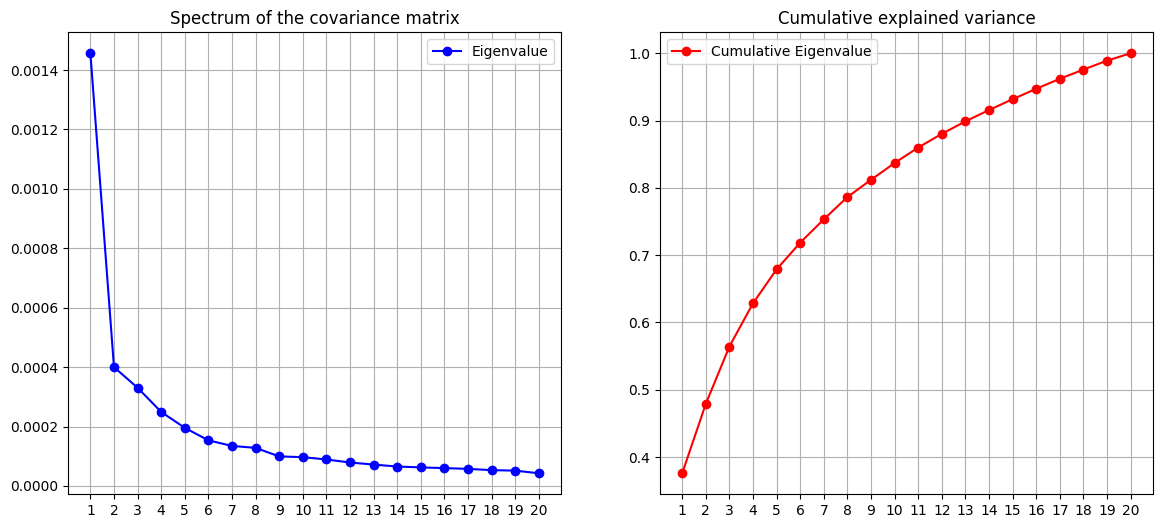

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the eigenvalues
ax[0].plot(range(1, n+1), eigenvals, marker='o', label='Eigenvalue', color='blue')
ax[0].grid()
ax[0].set_xticks(range(1, n+1))
ax[0].legend()
ax[0].set_title("Spectrum of the covariance matrix")

# Plotting the cumulative explained variance
ax[1].plot(range(1, n+1), np.cumsum(eigenvals) / np.cumsum(eigenvals)[-1], marker='o', label='Cumulative Eigenvalue', color='red')
ax[1].grid()
ax[1].set_xticks(range(1, n+1))
ax[1].legend()
ax[1].set_title("Cumulative explained variance")
plt.show()

Lastly, we compare our parametric and non-parametric estimates with a general rule of thumb based on a gaussian approximation. Our results are all more or less coherent with this bulpark estimate.

In [30]:
from scipy.stats import norm

In [31]:
# Case Study 1 - Q5: Plausibility check

W = [weights2, weights3, weights4]
ptfs = [ptf2_notional, ptf_notional, ptf_notional]
start_dates = [start_date2, start_date1, start_date2]
deltas = [1,1,10]

for j, w in enumerate(W):
    mu = log_returns.loc[start_dates[j]:date, w.index].mean()
    sigma = log_returns.loc[start_dates[j]:date, w.index].cov()
    C = log_returns.loc[start_dates[j]:date, w.index].corr()

    sVAR = np.zeros(len(w))

    for i in range(len(w)):
        std = norm.ppf(alpha)
        var_upper = deltas[j]*mu.iloc[i] + np.sqrt(deltas[j])*np.sqrt(sigma.iloc[i,i]) * std
        var_lower = deltas[j]*mu.iloc[i] - np.sqrt(deltas[j])*np.sqrt(sigma.iloc[i,i]) * std

        sVAR[i] =  ptfs[j] * w.iloc[i] * (abs(var_upper)+abs(var_lower))/2

    print(f"Rule of thumb: {np.sqrt(sVAR.T @ C @ sVAR)}")

Rule of thumb: 325154.22964392364
Rule of thumb: 490536.9018267195
Rule of thumb: 1061700.7671453904


## Case Study 2: MonteCarlo vs $\Delta$-Normal vs $\Delta-\Gamma$

In the second case study, we consider a portfolio of derivatives: in particular, we long the "Anheuser-Busch InBev" and its corresponding put, with strike $53$ euros and $3$ months maturity. The risk are measured using three different approachs: Full MonteCarlo, $\Delta$-Normal and $\Delta-\Gamma$ approximations. The informations about discount factors and zero rates are recovered from the `bootstrap_py` library.

In [32]:
from bootstrap_py import Bootstrap

In [33]:
b = Bootstrap.from_xls("MktData_CurveBootstrap.xls")
dates, discounts = b.fit()
discount_factors = pd.Series(discounts, index=dates)

First, we compute the *VaR* using a MonteCarlo procedure. Details on the option are defined below

In [34]:
# Case Study 2 - Q1: Monte-Carlo Simulation
# Parameters
date = business_date_offset(pd.Timestamp(2023, 1, 31))

time_horizon = 2  # In years

stock_name = "Anheuser-Busch InBev"
stock_notional = 5_509_000

put_expiry = business_date_offset(pd.Timestamp(2023, 4, 5))
strike = 53
iv = 0.185  # Implied volatility
d = 0.03  # Dividend yield

delta = 10
alpha = 0.99

start_date = date - relativedelta(years=time_horizon)

stock_ticker = tickers_df[tickers_df["Name"] == stock_name]["Ticker"].values
stock_price = prices.loc[date][stock_ticker].values[0]
stock_number = stock_notional/stock_price
put_number = stock_number

In [35]:
# Case Study 2 - Q1: Monte-Carlo Simulation
# Zero rates from the bootstrap

von_log_returns = log_returns.loc[start_date:date, stock_ticker]

ttm = year_frac_act_x(date, put_expiry, 365)  # Time to maturity

# the maturity must be shortened by the delta
date_delta = business_date_offset(date + relativedelta(days=delta))
ttm_delta = year_frac_act_x(date_delta, put_expiry, 365)

# Loading and interpolating zero rates
zero_rates = b.zeroRates()
B = get_discount_factor_by_zero_rates_linear_interp(date, put_expiry, dates, discounts)
zero_rate = -np.log(B) / ttm

The option is priced according to Black-Scholes formula; the pricer has `black_scholes_option_pricer()` been defined in the `ex3_utilities.py` file. The method also computes the *Delta* and the *Gamma* of the option, which will be used later in the code

In [36]:
# Put price
put_price, put_delta, put_gamma = black_scholes_option_pricer(
    stock_price, strike, ttm, zero_rate, iv, d, return_delta_gamma=True
)

We can run $N$ simulations, sampling the risk factors from the last $2$ years log returns. Then we just update the stock and the option price.

In [37]:
N = int(1e4)

returns_values = log_returns.loc[start_date:date, stock_ticker].values.flatten()  # Convert to NumPy array for speed

np.random.seed(42)

B2 = get_discount_factor_by_zero_rates_linear_interp(date_delta, put_expiry, dates, discounts)
zero_rate2 = -np.log(B2) / ttm_delta

risk_factor_10d = np.sum(
    np.random.choice(returns_values, size=(N, 10), replace=True), axis=1
)

simulated_stock_prices = stock_price * np.exp(risk_factor_10d)

simulated_put_prices = black_scholes_option_pricer(
    simulated_stock_prices, strike, ttm_delta, zero_rate2, iv, d
)

After running the simulation, we can compute the *VaR* using an Historical Simulation, as already discussed several times. 

In [38]:
loss = (
    -(simulated_put_prices - put_price) * put_number
    - (simulated_stock_prices - stock_price) * stock_number
)
sorted_loss = sorted(
    loss,
    reverse=True,
)

index = np.floor((1 - alpha) * len(sorted_loss)).astype(int)
VaR_MC = sorted_loss[index - 1]
print(f"Case Study 2 - Q1: Monte-Carlo VaR: €{VaR_MC:,.2f}")

Case Study 2 - Q1: Monte-Carlo VaR: €271,465.82


Instead of evaluating the price of the option at every iteration, which for more complicated derivatives could be more computationally intensive often leading to other nested monte carlos, we use a $\Delta$-Normal approximation. This is based on the Taylor expansion of the option price, which is a function of the underlying stock price.

In [39]:
# Case study 2 - Q1: Delta Normal Approach
loss = (
    - (put_delta * put_number + stock_number) * stock_price * risk_factor_10d
)
sorted_loss = sorted(
    loss,
    reverse=True,
)

index = np.floor((1 - alpha) * len(sorted_loss)).astype(int)
VaR_MC = sorted_loss[index - 1]
print(f"Case Study 2 - Q1: Monte-Carlo VaR: €{VaR_MC:,.2f}")

Case Study 2 - Q1: Monte-Carlo VaR: €462,820.46


The *VaR* are quite different. The Monte Carlo approach is inherently more precise: such a discrepancy suggests the our $\Delta$-Normal approximation is far from accurate. To improve it, we could also consider the quadratic term in the Taylor expasion, related to the second order option greek $\Gamma$.

In [40]:
# Case Study 2 - Q2: We can improved the delta normal approach introducing a second order term ->
# Delta-Gamma Approach

loss = (
    - (put_delta * put_number + stock_number) * stock_price * risk_factor_10d
    - 0.5 * put_gamma * put_number * (stock_price ** 2) * (risk_factor_10d ** 2)
)
sorted_loss = sorted(
    loss,
    reverse=True,
)

index = np.floor((1 - alpha) * len(sorted_loss)).astype(int)
VaR_MC = sorted_loss[index - 1]
print(f"Case Study 2 - Q1: Monte-Carlo VaR: €{VaR_MC:,.2f}")

Case Study 2 - Q1: Monte-Carlo VaR: €286,883.13


Considering also the $\Gamma$ term, the two results are much closer.

## Case Study 3: Pricing in presence of counterparty risk

The payoff structure of a Cliquet option is made up of $5$ different forward starting put $S_{t_{i-1}}-S_{t_i}$. We price the contract using a Monte Carlo simulation to generate the cashflows, to later discount them according to $\bar{B}(t_0,t_i)$. This discount factor should also account for the survival probability of our counter-party, as will be discussed below.

In [41]:
def get_forward_zero_rate(today, date1, date2: pd.Timestamp):
    B1 = get_discount_factor_by_zero_rates_linear_interp(today, date1, dates, discounts)
    B2 = get_discount_factor_by_zero_rates_linear_interp(today, date2, dates, discounts)
    fwd_B = B2 / B1
    return -np.log(fwd_B) / year_frac_act_x(date1, date2, 365)

In [42]:
# Case Study 3: Pricing in presence of counterparty risk
S0 = 2.5
vol = 0.25
notional = 50e6
N = int(1e5)
alpha = 0.05

discounts_option = np.array([
    get_discount_factor_by_zero_rates_linear_interp(date, date + relativedelta(years=i), dates, discounts)
    for i in range(1, 6)
])

fwd_zero_rates_vector = np.array([
    get_forward_zero_rate(date, date + relativedelta(years=i), date + relativedelta(years=i+1))
    for i in range(5)
])

# taken from Assignment3 - with accrual
survival = np.array([1.0000, 0.9934, 0.9855, 0.9767, 0.9677, 0.9581])

np.random.seed(42)
Z = np.random.normal(size=(N, 5))  

drift = fwd_zero_rates_vector - 0.5 * vol**2
log_increments = drift + vol * Z

S = np.zeros((N, 6))
S[:, 0] = S0
S[:, 1:] = S0 * np.exp(np.cumsum(log_increments, axis=1))

payoffs = np.maximum(S[:, :-1] - S[:, 1:], 0)

coupon = payoffs.mean(axis=0)

price = np.sum(coupon * discounts_option[:5] * survival[1:])

In [43]:
print(f"Price of the Cliquet (Single): {price}")
print(f"Price of the Cliquet (Notional): {notional*price:0.2f}")

Price of the Cliquet (Single): 1.0363654869666081
Price of the Cliquet (Notional): 51818274.35


In [44]:
prices = np.sum(payoffs * discounts_option[:5] * survival[1:], axis=1)

mu = np.mean(prices)
sigma = np.std(prices, ddof=1)

z = norm.ppf(1 - alpha/2)

CI_lower = mu - z * sigma / np.sqrt(N)
CI_upper = mu + z * sigma / np.sqrt(N)

print("Confidence interval: [{:.4f}, {:.4f}]".format(CI_lower, CI_upper))

Confidence interval: [1.0330, 1.0397]


It is ISP's interest to be percevied as secure as possible, in order to sell the contract at higher prices. In pratice, ISP trader would run the very same model, imposing the survival probabilities of the bank itself to be equal to one, $P(t_0,t_i)=1$.

In [48]:
price_isp = np.sum(coupon * discounts_option[:5])
print(f"Price of the Cliquet (Single): {price_isp}")
print(f"Price of the Cliquet (Notional): {notional*price_isp:0.2f}")

Price of the Cliquet (Single): 1.0616950261342937
Price of the Cliquet (Notional): 53084751.31


As expected, the option is worth more. On the total value of the contract of $50Mln$, this results in almost a one million more.